In [2]:
import numpy, scipy, matplotlib
import matplotlib.pyplot as plt
import pyeq3


##########################################################
# text data section
dataString = '''
30.04   1.97
30.43   1.92
30.84   1.86
31.26   1.81
31.7    1.76
32.15   1.72
32.62   1.67
33.11   1.62
33.61   1.57
34.13   1.52
34.67   1.47
35.23   1.43
35.8    1.38
36.4    1.33
37.02   1.29
37.66   1.24
38.32   1.2
39      1.16
41.99   0.985
45.43   0.835
49.37   0.7
53.89   0.583
57.72   0.504
61.97   0.433
66.68   0.37
71.91   0.315
77.7    0.267
84.13   0.225
91.26   0.189
99.17   0.157
114.3   0.116
128.5   0.0887
144.7   0.0675
163.4   0.0507
184.8   0.0375
209.4   0.0274
237.6   0.0197
270     0.014
307.2   0.00994
338.7   0.0075
373.6   0.00574
412.4   0.00433
455.3   0.00325
503 0.00243
555.9   0.00182
614.5   0.00136
679.5   0.00102
751.6   0.000749
831.7   0.000557
920.4   0.000413
'''


##########################################################
# pyeq3 fitting section

# this example fits to default lowest sum-of-squared errors
equation = pyeq3.Models_2D.Exponential.Hocket_Sherby('SSQABS')

# note that True is passed here to indicate weighted data, for unweighted pass False
pyeq3.dataConvertorService().ConvertAndSortColumnarASCII(dataString, equation, False)

print("Fitting data...")
equation.Solve()


##########################################################
# text output section for fitted parameter values

print("Equation:", equation.GetDisplayName(), str(equation.GetDimensionality()) + "D")
print("Fitting target of", equation.fittingTargetDictionary[equation.fittingTarget], '=', equation.CalculateAllDataFittingTarget(equation.solvedCoefficients))
print("Fitted Parameters:")
for i in range(len(equation.solvedCoefficients)):
    print("    %s = %-.16E" % (equation.GetCoefficientDesignators()[i], equation.solvedCoefficients[i]))
print()


##########################################################
# calculate absolute, relative, and percent errors from the fit
equation.CalculateModelErrors(equation.solvedCoefficients, equation.dataCache.allDataCacheDictionary)


##########################################################
# this section prints information on each individual data point
for i in range(len(equation.dataCache.allDataCacheDictionary['DependentData'])):
    print('X:', equation.dataCache.allDataCacheDictionary['IndependentData'][0][i],)
    print('Y:', equation.dataCache.allDataCacheDictionary['DependentData'][i],)
    print('Model:', equation.modelPredictions[i],)
    print('Abs. Error:', equation.modelAbsoluteError[i],)
    if not equation.dataCache.DependentDataContainsZeroFlag:
        print('Rel. Error:', equation.modelRelativeError[i],)
        print('Percent Error:', equation.modelPercentError[i])
    else:
        print()
print()


##########################################################
# overall fit and parameter statistics output section

equation.CalculateCoefficientAndFitStatistics()

if equation.upperCoefficientBounds or equation.lowerCoefficientBounds:
    print('You entered coefficient bounds. Parameter statistics may')
    print('not be valid for parameter values at or near the bounds.')
    print()

print('Degress of freedom error',  equation.df_e)
print('Degress of freedom regression',  equation.df_r)

if equation.rmse == None:
    print('Root Mean Squared Error (RMSE): n/a')
else:
    print('Root Mean Squared Error (RMSE):',  equation.rmse)

if equation.r2 == None:
    print('R-squared: n/a')
else:
    print('R-squared:',  equation.r2)

if equation.r2adj == None:
    print('R-squared adjusted: n/a')
else:
    print('R-squared adjusted:',  equation.r2adj)

if equation.Fstat == None:
    print('Model F-statistic: n/a')
else:
    print('Model F-statistic:',  equation.Fstat)

if equation.Fpv == None:
    print('Model F-statistic p-value: n/a')
else:
    print('Model F-statistic p-value:',  equation.Fpv)

if equation.ll == None:
    print('Model log-likelihood: n/a')
else:
    print('Model log-likelihood:',  equation.ll)

if equation.aic == None:
    print('Model AIC: n/a')
else:
    print('Model AIC:',  equation.aic)

if equation.bic == None:
    print('Model BIC: n/a')
else:
    print('Model BIC:',  equation.bic)


print()
print("Individual Parameter Statistics:")
for i in range(len(equation.solvedCoefficients)):
    if type(equation.tstat_beta) == type(None):
        tstat = 'n/a'
    else:
        tstat = '%-.5E' %  ( equation.tstat_beta[i])

    if type(equation.pstat_beta) == type(None):
        pstat = 'n/a'
    else:
        pstat = '%-.5E' %  ( equation.pstat_beta[i])

    if type(equation.sd_beta) != type(None):
        print("Coefficient %s = %-.16E, std error: %-.5E" % (equation.GetCoefficientDesignators()[i], equation.solvedCoefficients[i], equation.sd_beta[i]))
    else:
        print("Coefficient %s = %-.16E, std error: n/a" % (equation.GetCoefficientDesignators()[i], equation.solvedCoefficients[i]))
    print("          t-stat: %s, p-stat: %s, 95 percent confidence intervals: [%-.5E, %-.5E]" % (tstat,  pstat, equation.ci[i][0], equation.ci[i][1]))


print()
print("Coefficient Covariance Matrix:")
for i in  equation.cov_beta:
    print(i)


##########################################################
# graphics output section
def ModelScatterGraph(equation, graphWidth, graphHeight):
    f = plt.figure(figsize=(graphWidth/100.0, graphHeight/100.0), dpi=100)
    axes = f.add_subplot(111)
    y_data = equation.dataCache.allDataCacheDictionary['DependentData']
    x_data = equation.dataCache.allDataCacheDictionary['IndependentData'][0]

    # first the raw data as a scatter plot
    axes.plot(x_data, y_data,  'D')

    # create data for the fitted equation plot
    xModel = numpy.linspace(min(x_data), max(x_data))

    tempcache = equation.dataCache # store the data cache
    equation.dataCache = pyeq3.dataCache()
    equation.dataCache.allDataCacheDictionary['IndependentData'] = numpy.array([xModel, xModel])
    equation.dataCache.FindOrCreateAllDataCache(equation)
    yModel = equation.CalculateModelPredictions(equation.solvedCoefficients, equation.dataCache.allDataCacheDictionary)
    equation.dataCache = tempcache # restore the original data cache

    # now the model as a line plot
    axes.plot(xModel, yModel)

    axes.set_title(equation.GetDisplayName()) # add a title
    axes.set_xlabel('X Data') # X axis data label
    axes.set_ylabel('Y Data') # Y axis data label

    plt.show()
    plt.close('all') # clean up after using pyplot

Fitting data...


C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Equation: Hocket-Sherby 2D
Fitting target of sum of squared absolute error = 0.000347798995615249
Fitted Parameters:
    a = -2.1795455665237773E-03
    b = 1.2081473620717192E+01
    c = 2.9672807742107210E+02
    d = -2.1805735631860093E+00

X: 920.4
Y: 0.000413
Model: -0.0009454020175105882
Abs. Error: -0.0013584020175105881
Rel. Error: -3.289109001236291
Percent Error: -328.91090012362906
X: 831.7
Y: 0.000557
Model: -0.00064023221631615
Abs. Error: -0.00119723221631615
Rel. Error: -2.1494294727399463
Percent Error: -214.94294727399463
X: 751.6
Y: 0.000749
Model: -0.0002598972463534466
Abs. Error: -0.0010088972463534467
Rel. Error: -1.3469923182289008
Percent Error: -134.69923182289008
X: 679.5
Y: 0.00102
Model: 0.00021220808204702735
Abs. Error: -0.0008077919179529727
Rel. Error: -0.7919528607382085
Percent Error: -79.19528607382085
X: 614.5
Y: 0.00136
Model: 0.0007984652103711909
Abs. Error: -0.0005615347896288092
Rel. Error: -0.41289322766824205
Percent Error: -41.289322766824206

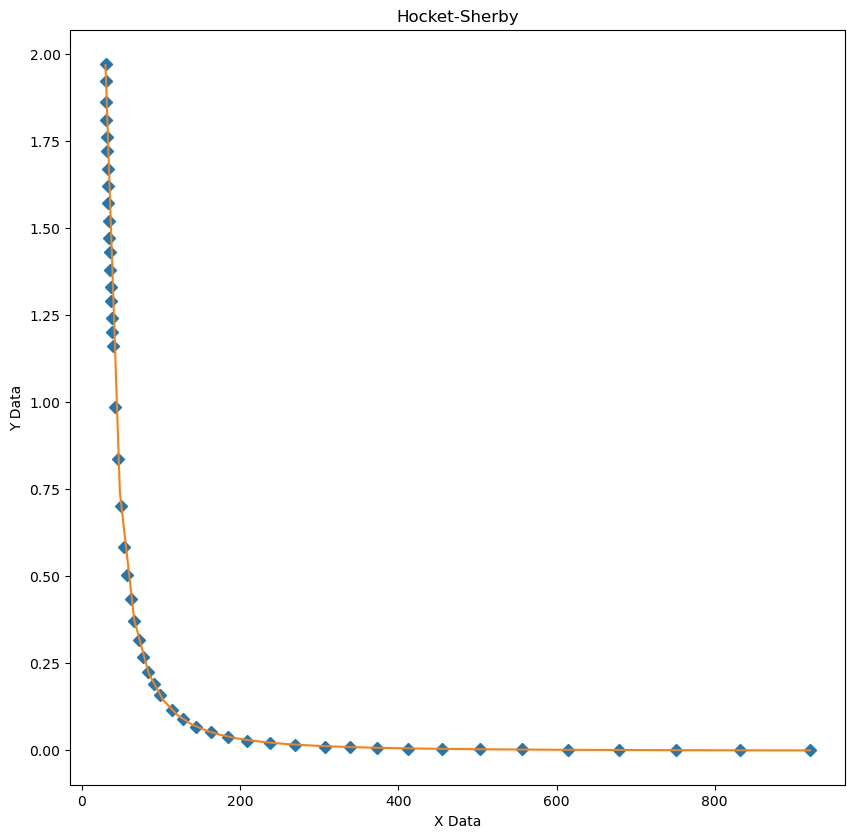

In [7]:
ModelScatterGraph(equation, 1000, 1000)